In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tf_keras
from tensorflow.keras import layers, models, optimizers

In [3]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


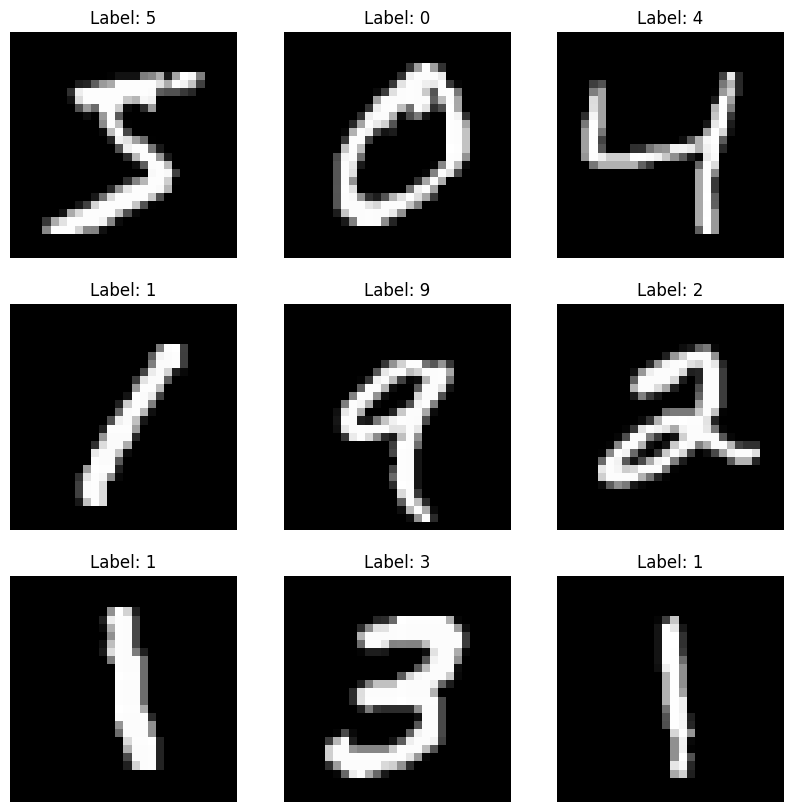

In [198]:
# Define a function to display a grid of images
def display_images(images, labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Display the first 9 images from the training set
display_images(x_train, y_train, num_images=9)

In [4]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [15]:
# Create pairs of augmented images
def create_pairs(images):
    pairs = []
    labels = []
    for img in images:
        aug1 = data_augmentation(img)
        aug2 = data_augmentation(img)
        pairs.append((aug1, aug2))
        labels.append(1)  # positive pair
    return pairs, labels

train_pairs, train_labels = create_pairs(x_train)
test_pairs, test_labels = create_pairs(x_test)

In [16]:
# Convert to numpy arrays
train_pairs = np.array(train_pairs)
test_pairs = np.array(test_pairs)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [174]:
# Define the encoder model
def create_encoder():
    model = tf_keras.models.Sequential([
        tf_keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf_keras.layers.MaxPooling2D((2, 2)),
        tf_keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf_keras.layers.MaxPooling2D((2, 2)),
        tf_keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf_keras.layers.GlobalAveragePooling2D(),
        tf_keras.layers.Dense(128, activation='relu'),
        tf_keras.layers.Dense(10, activation='relu')
    ])
    return model

encoder = create_encoder()

In [176]:
# Define the contrastive loss function
def contrastive_loss(hidden_1, hidden_2, temperature=0.1):
    hidden_1 = tf.math.l2_normalize(hidden_1, axis=1)
    hidden_2 = tf.math.l2_normalize(hidden_2, axis=1)
    batch_size = tf.shape(hidden_1)[0]
    labels = tf.eye(batch_size)
    
    logits = tf.matmul(hidden_1, hidden_2, transpose_b=True) / temperature
    loss = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

In [177]:
# Define the training step
optimizer = optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step(pair, label):
    with tf.GradientTape() as tape:
        hidden_1 = encoder(pair[:, 0], training=True)
        hidden_2 = encoder(pair[:, 1], training=True)
        loss = contrastive_loss(hidden_1, hidden_2)
    
    gradients = tape.gradient(loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
    return loss

In [178]:
# Training loop
epochs = 10
batch_size = 64
num_batches = len(train_pairs) // batch_size

for epoch in range(epochs):
    epoch_loss = 0
    for i in range(num_batches):
        batch_pairs = train_pairs[i*batch_size:(i+1)*batch_size]
        batch_labels = train_labels[i*batch_size:(i+1)*batch_size]
        loss = train_step(batch_pairs, batch_labels)
        epoch_loss += loss.numpy()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/num_batches}')

Epoch 1, Loss: 1.8953900257067848
Epoch 2, Loss: 1.4534858516084475
Epoch 3, Loss: 1.3602121146028043
Epoch 4, Loss: 1.3180895799506562
Epoch 5, Loss: 1.2913559340616427
Epoch 6, Loss: 1.2732442804436293
Epoch 7, Loss: 1.2589879398539328
Epoch 8, Loss: 1.246844800584726
Epoch 9, Loss: 1.2378120623377877
Epoch 10, Loss: 1.2285014521986597


In [179]:
# Testing the model on test set (similar logic can be used for evaluation)
def test_model(test_pairs, test_labels):
    hidden_1 = encoder(test_pairs[:, 0], training=False)
    hidden_2 = encoder(test_pairs[:, 1], training=False)
    loss = contrastive_loss(hidden_1, hidden_2)
    return loss

test_loss = test_model(test_pairs, test_labels)
print(f'Test Loss: {test_loss.numpy()}')

Test Loss: 5.951152324676514


In [81]:
def cosine_similarity(vec1, vec2):
    """
    Calculate the cosine similarity between two numpy vectors.

    Parameters:
    vec1 (numpy.ndarray): First vector
    vec2 (numpy.ndarray): Second vector

    Returns:
    float: Cosine similarity between vec1 and vec2
    """
    # Ensure the vectors are numpy arrays
    vec1 = np.asarray(vec1)
    vec2 = np.asarray(vec2)

    # Calculate the dot product
    dot_product = np.dot(vec1, vec2)
    
    # Calculate the magnitudes (norms) of the vectors
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Calculate the cosine similarity
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0  # Avoid division by zero
    else:
        return dot_product / (norm_vec1 * norm_vec2)

# Example usage
vec1 = np.array([1, 2, 3])
vec2 = np.array([4, 5, 6])
similarity = cosine_similarity(vec1, vec2)
print(f"Cosine similarity: {similarity}")


Cosine similarity: 0.9746318461970762


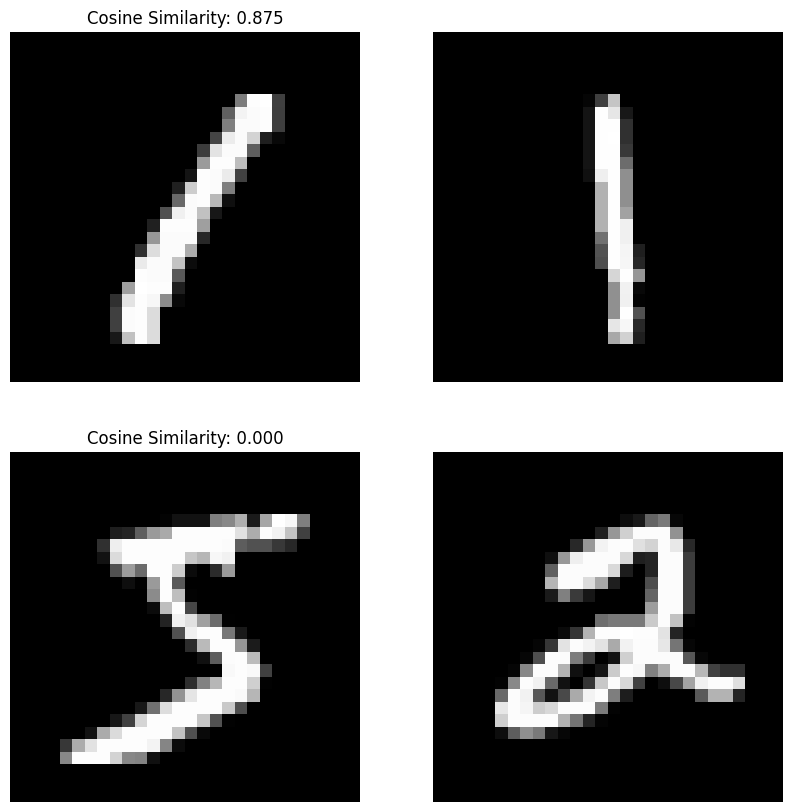

In [191]:
# Define a function to display a grid of images
def display_image_pair(images, index_pairs):
    plt.figure(figsize=(10, 10))
    num_rows = min(3, len(index_pairs))
    for row, pair in enumerate(index_pairs):
        # compute cosine similarity
        score = cosine_similarity(
            np.array(encoder(x_train[[pair[0]-1],:,:,:], training=False))[0,:],
            np.array(encoder(x_train[[pair[1]-1],:,:,:], training=False))[0,:]
        )
        for idx, i in enumerate(pair):
            pos = (row % num_rows) * 2 + idx + 1
            plt.subplot(num_rows, 2, pos)
            plt.imshow(images[i-1], cmap='gray')
            if pos % 2 == 1:
                plt.title(f"Cosine Similarity: {score:.3f}")
            plt.axis('off')
    plt.show()

# Display a pair of images from the training set
display_image_pair(x_train, [[4, 9], [1, 6]])